# Clustering redundant alignments from the database

In [11]:
import psycopg2
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import json

database = 'fomc'
conn = psycopg2.connect("dbname=" + database + " user=abarciauskas")
cur = conn.cursor()

nw_score_thresh = 0
year = 2005

cur.execute("SELECT count(*) FROM alignments WHERE Year = '" + str(year) + "'")
print 'Total number of alignments from year ' + str(year) + ': ' + str(int(cur.fetchone()[0]))

cur.execute(
    "SELECT Doc1Id,Doc2Id,nwscore FROM alignments WHERE Year = '" 
    + str(year) + "' AND nwscore >= " + str(nw_score_thresh)
)
redundancies = cur.fetchall()
len(redundancies)

Total number of alignments from year 2005: 523776


274

## Step 1: Create the graph

The graph is comprised a list of edges (a vertex tuple) and a dictionary of vertices.

In [12]:
def create_graph(alignments):
    edges = [tuple([x[0],x[1]]) for x in alignments]
    vertices = {}
    for edge in edges:
        v1 = edge[0]
        v2 = edge[1]
        if v1 in vertices.keys():
            vertices[v1].add(v2)
        else:
            vertices[v1] = {v2}
        if v2 in vertices.keys():
            vertices[v2].add(v1)
        else:
            vertices[v2] = {v1}
    return [edges, vertices]

edges, vertices = create_graph(redundancies)
print len(vertices)
print len(edges)

179
274


In [50]:
# Testing
# vertices = {1: {5}, 2: {3,4}, 3: {2,4}, 4: {2,3}, 5: {1}}
# edges = [{1,5}, {2,3}, {2,4}, {3,2}, {3,4}]

In [13]:
# need to find disconnected graphs
graphs = []
unvisited = set(vertices.keys())

# Detect distinct graphs
while len(unvisited) > 0:
    # for every vertex, find all of its connected components and recurse on those vertices
    visited = []
    current_vertex = unvisited.pop()
    visited.append(current_vertex)
    stack_to_visit = list(vertices[current_vertex])
    while len(stack_to_visit) > 0:
        current_vertex = stack_to_visit.pop()
        current_adj_vtcs = vertices[current_vertex]
        if current_vertex not in visited: visited.append(current_vertex)
        if current_vertex in unvisited: unvisited.remove(current_vertex)        
        for v in current_adj_vtcs:
            if v not in visited:
                stack_to_visit.insert(0, v)
    graphs.append(visited)

print len(unvisited)
print len(visited)
print len(graphs)

0
2
56


In [14]:
# What is the distribution of these clusters?
cluster_sizes = [len(cluster) for cluster in graphs]
cluster_sizes[0:10]

[6, 6, 8, 2, 2, 2, 2, 3, 2, 2]

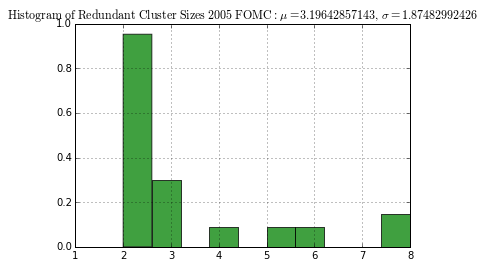

In [36]:
%matplotlib inline

# the histogram of the data
n, bins, patches = plt.hist(cluster_sizes, 10, normed=1, facecolor='green', alpha=0.75)
mu = np.mean(cluster_sizes)
sigma = np.std(cluster_sizes)
plt.title(r'$\mathrm{Histogram\ of\ Redundant\ Cluster\ Sizes\ ' + str(year) + '\ ' + database.upper() + ':}\ \mu='
          '' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
# Note: there is a value lower, ths has cut some extremes
plt.grid(True)
plt.plot()
plt.savefig('redundant_cluster_sizes_' + database + '.png')

In [26]:
# Filter clusters to those with at least 4 instances
threshold = 7
clusters = filter(lambda x: len(x) >= threshold, graphs)
len(clusters)

5

In [27]:
# Find cluster centroid
for cluster in clusters:
    degrees = [len(vertices[vertex]) for vertex in cluster]
    centroid_id = cluster[degrees.index(max(degrees))]
    cur.execute("SELECT Original FROM processed_documents WHERE Id = " + str(centroid_id))
    centroid = cur.fetchall()
    print centroid
    print ''

[('The_Manager also reported on developments in domestic financial markets and on System open market transactions in government securities and federal agency obligations during the period December 14, 2004 to February 1, 2005.',)]

[('At the conclusion of the discussion, the Committee voted to authorize and direct the Federal_Reserve_Bank of New_York, until it was instructed otherwise, to execute transactions in the System_Account in accordance with the following domestic policy directive:" The_Federal_Open_Market_Committee seeks monetary and financial conditions that will foster price stability and promote sustainable growth in output. To further its long-run objectives, the Committee in the immediate future seeks conditions in reserve markets consistent with increasing the federal funds rate to an average of around 3 percent." The vote encompassed approval of the paragraph below for inclusion in the statement to be released shortly after the meeting:" The_Committee perceives that, wi

In [8]:
conn.close()